In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import itertools
df = pd.read_csv("Energy.csv")
df.head()

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Year,Energy
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   Energy  215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


In [5]:
#CONVERT YEAR -> DD/MM/YEAR
dateparse = lambda x: pd.to_datetime(x, format='%Y', errors = 'coerce')
df = pd.read_csv("Energy.csv", parse_dates=['Year'], index_col='Year', date_parser=dateparse) 
df.head()

,Energy
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


<AxesSubplot:xlabel='Year'>

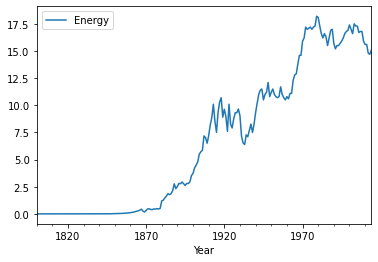

In [6]:
df.plot()

In [7]:
df.describe()

,Energy
count,215.000000
mean,6.741970
std,6.522437
min,0.001750
25%,0.041050
50%,6.390000
75%,11.500000
max,18.200000


In [8]:
df.dtypes

Energy    float64
dtype: object

In [9]:
#MODEL BUILDING ON STATIONARY DATA
#TEST STATIONARY DATA
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
def TestStationaryPlot(df):
    rol_mean = df.rolling(window = 20, center = False).mean()
    rol_std = df.rolling(window = 20, center = False).std()
    
    plt.plot(df, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(df, cutoff = 0.01):
    df_test = adfuller(df, autolag = 'AIC')
    df_test_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in df_test[4].items():
        df_test_output['Critical Value (%s)'%key] = value
    print(df_test_output)
    
    if df_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")
        

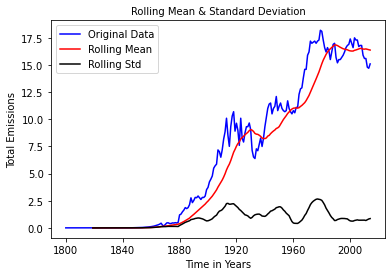

In [10]:
TestStationaryPlot(df)

In [12]:
TestStationaryAdfuller(df)
#The emissions mean and the variation in standard deviation (black line) clearly vary with time. This shows that the series has a trend. So, it is not a stationary. Also, the Test Statistic is greater than the critical values with 90%, 95% and 99% confidence levels. Hence, no evidence to accept the null hypothesis. Therefore the series is non stationary.#

Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


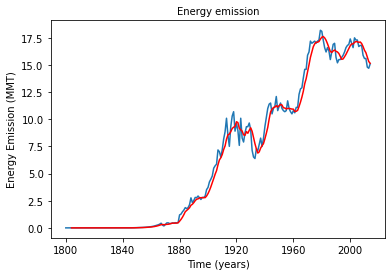

In [13]:
#Tranform data to stationary
#1 MOVING AVERAGE
moving_avg = df.rolling(5).mean()
plt.plot(df)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('Energy Emission (MMT)', fontsize = 10)
plt.title('Energy emission', fontsize = 10)
plt.show()

In [14]:
moving_avg_diff = df - moving_avg
moving_avg_diff.head(13)

,Energy
Year,
1800-01-01,NaN
1801-01-01,NaN
1802-01-01,NaN
1803-01-01,NaN
1804-01-01,-0.000128
1805-01-01,-0.000124
1806-01-01,-0.000130
1807-01-01,-0.000126
1808-01-01,-0.000124


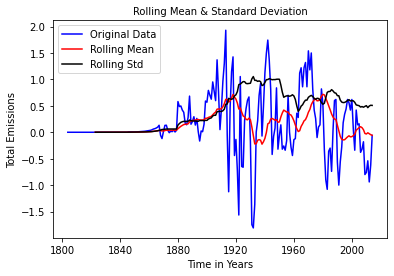

In [15]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [16]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                  -3.944115
p-value                          0.001733
#Lags Used                       4.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64
Failed to reject null hypothesis. Data is stationary


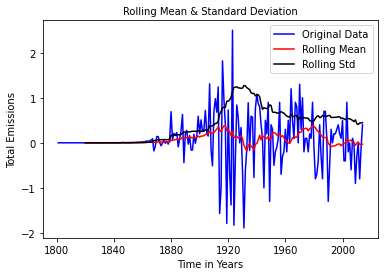

In [18]:
#ELIMINATION FIRST AND SESONALITY DIFFERENCING
df_first_difference = df - df.shift(1)  
TestStationaryPlot(df_first_difference.dropna(inplace=False))

In [19]:
TestStationaryAdfuller(df_first_difference.dropna(inplace=False))

Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Failed to reject null hypothesis. Data is stationary


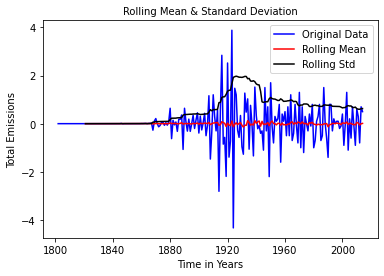

In [20]:
df_seasonal_first_difference = df_first_difference - df_first_difference.shift(1)  
TestStationaryPlot(df_seasonal_first_difference.dropna(inplace=False))
#We are considering this seasonal first difference for further analysis because it looks more stationary

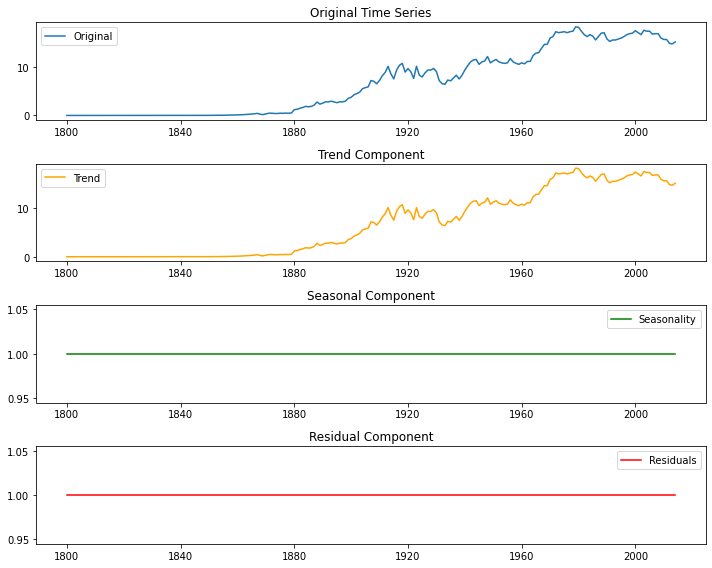

In [23]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(df, period=1, model="multiplicative")

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting
plt.figure(figsize=(10, 8))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(df, label='Original')
plt.title('Original Time Series')
plt.legend()

# Trend component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend()

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component')
plt.legend()

# Residual component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()


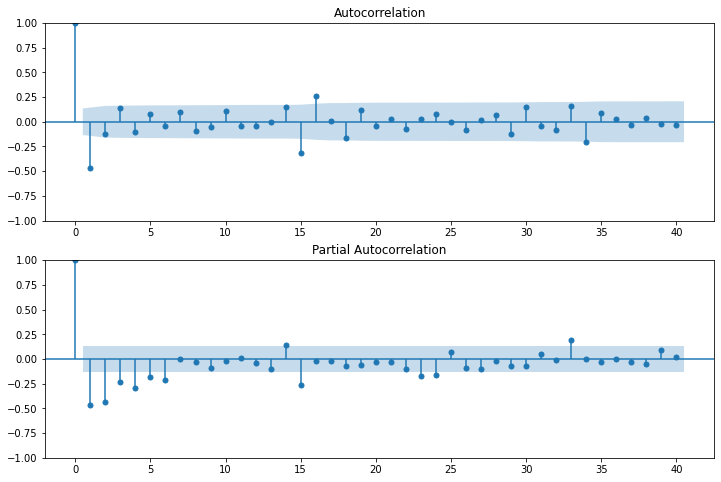

In [24]:
#Here we can see that the trend, no seasonaltiy in data and we can model the trend. Here original data and trend both are equal.
#ACF and PACF plots:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_seasonal_first_difference.dropna(inplace=False), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_seasonal_first_difference.dropna(inplace=False), lags=40, ax=ax2)

In [25]:
df_seasonal_first_difference.head()

,Energy
Year,
1800-01-01,NaN
1801-01-01,NaN
1802-01-01,0.00001
1803-01-01,-0.00001
1804-01-01,0.00001


In [26]:
X = df_seasonal_first_difference.dropna(inplace=False)
X.head()

,Energy
Year,
1802-01-01,1.000000e-05
1803-01-01,-1.000000e-05
1804-01-01,1.000000e-05
1805-01-01,-8.673617e-19
1806-01-01,-1.000000e-05


In [28]:
# Create Training and Test
train = X.iloc[:-20]
test = X.iloc[-20:]
print(train.shape,test.shape)

(193, 1) (20, 1)


In [30]:
# Define the percentage of data for training
percentage_train = 80  # for example, 80% for training
#Train=80%
#Tst data =20%

# Calculate the number of rows for training and testing
total_rows = len(X)
train_rows = int(total_rows * (percentage_train / 100))
test_rows = total_rows - train_rows

# Split the data
train = X.iloc[:train_rows]
test = X.iloc[train_rows:]

print("Train set size:", len(train))
print("Test set size:", len(test))


Train set size: 170
Test set size: 43


In [31]:
train.head()

,Energy
Year,
1802-01-01,1.000000e-05
1803-01-01,-1.000000e-05
1804-01-01,1.000000e-05
1805-01-01,-8.673617e-19
1806-01-01,-1.000000e-05


In [32]:
test.head()

,Energy
Year,
1972-01-01,7.000000e-01
1973-01-01,-1.200000e+00
1974-01-01,3.000000e-01
1975-01-01,-3.552714e-15
1976-01-01,-3.000000e-01


In [33]:
#Finding p,d,q
import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.673
ARIMA(0, 0, 1) RMSE=0.545
ARIMA(0, 0, 2) RMSE=0.558
ARIMA(0, 1, 0) RMSE=1.100
ARIMA(0, 1, 1) RMSE=0.673
ARIMA(0, 1, 2) RMSE=0.538
ARIMA(0, 2, 0) RMSE=1.989
ARIMA(0, 2, 1) RMSE=1.103
ARIMA(0, 2, 2) RMSE=0.706
ARIMA(1, 0, 0) RMSE=0.648
ARIMA(1, 0, 1) RMSE=0.555
ARIMA(1, 0, 2) RMSE=0.544
ARIMA(1, 1, 0) RMSE=0.923
ARIMA(1, 1, 1) RMSE=0.648
ARIMA(1, 1, 2) RMSE=0.547
ARIMA(1, 2, 0) RMSE=1.417
ARIMA(1, 2, 1) RMSE=0.925
ARIMA(1, 2, 2) RMSE=0.733
ARIMA(2, 0, 0) RMSE=0.613
ARIMA(2, 0, 1) RMSE=0.561
ARIMA(2, 0, 2) RMSE=0.560
ARIMA(2, 1, 0) RMSE=0.856
ARIMA(2, 1, 1) RMSE=0.613
ARIMA(2, 1, 2) RMSE=0.552
ARIMA(2, 2, 0) RMSE=1.260
ARIMA(2, 2, 1) RMSE=0.858
ARIMA(2, 2, 2) RMSE=0.617
ARIMA(3, 0, 0) RMSE=0.582
ARIMA(3, 0, 1) RMSE=0.559
ARIMA(3, 0, 2) RMSE=0.562
ARIMA(3, 1, 0) RMSE=0.783
ARIMA(3, 1, 1) RMSE=0.582
ARIMA(3, 1, 2) RMSE=0.618
ARIMA(3, 2, 0) RMSE=1.166
ARIMA(3, 2, 1) RMSE=0.785
ARIMA(3, 2, 2) RMSE=0.655
ARIMA(4, 0, 0) RMSE=0.557
ARIMA(4, 0, 1) RMSE=0.587
ARIMA(4, 0, 

In [34]:
#0, 1, 2
model_arima = ARIMA(train['Energy'],order = (0,1,2))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Energy   No. Observations:                  170
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -148.353
Date:                Sun, 05 May 2024   AIC                            302.706
Time:                        21:10:39   BIC                            312.095
Sample:                    01-01-1802   HQIC                           306.516
                         - 01-01-1971                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9991      2.339     -0.855      0.393      -6.583       2.585
ma.L2          0.9996      2.337      0.428      0.669      -3.581       5.581
sigma2         0.3071      0.721      0.426      0.670      -1.107       1.721
===================================================================================
Ljung-Box (L1) (Q):                   1.52   Jarque-Bera (JB):               184.42
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):          117961.20   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
model_ar = AutoReg(train,lags = 6).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                 Energy   No. Observations:                  170
Model:                     AutoReg(6)   Log Likelihood                -136.827
Method:               Conditional MLE   S.D. of innovations              0.557
Date:                Sun, 05 May 2024   AIC                            289.653
Time:                        21:12:10   BIC                            314.452
Sample:                    01-01-1808   HQIC                           299.721
                         - 01-01-1971                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.044      0.450      0.653      -0.066       0.105
Energy.L1     -1.0307      0.075    -13.674      0.000      -1.178      -0.883
Energy.L2     -1.0651      0.103    -10.377      0.0

In [37]:
### make prediction on test set
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

1972-01-01   -0.086380
1973-01-01    0.001632
1974-01-01    0.001632
1975-01-01    0.001632
1976-01-01    0.001632
1977-01-01    0.001632
1978-01-01    0.001632
1979-01-01    0.001632
1980-01-01    0.001632
1981-01-01    0.001632
1982-01-01    0.001632
1983-01-01    0.001632
1984-01-01    0.001632
1985-01-01    0.001632
1986-01-01    0.001632
1987-01-01    0.001632
1988-01-01    0.001632
1989-01-01    0.001632
1990-01-01    0.001632
1991-01-01    0.001632
1992-01-01    0.001632
1993-01-01    0.001632
1994-01-01    0.001632
1995-01-01    0.001632
1996-01-01    0.001632
1997-01-01    0.001632
1998-01-01    0.001632
1999-01-01    0.001632
2000-01-01    0.001632
2001-01-01    0.001632
2002-01-01    0.001632
2003-01-01    0.001632
2004-01-01    0.001632
2005-01-01    0.001632
2006-01-01    0.001632
2007-01-01    0.001632
2008-01-01    0.001632
2009-01-01    0.001632
2010-01-01    0.001632
2011-01-01    0.001632
2012-01-01    0.001632
2013-01-01    0.001632
2014-01-01    0.001632
Freq: AS-JA

In [39]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

1972-01-01    0.114778
1973-01-01    0.323064
1974-01-01   -0.155579
1975-01-01    0.054239
1976-01-01   -0.059303
1977-01-01    0.108803
1978-01-01   -0.153236
1979-01-01    0.065136
1980-01-01    0.082311
1981-01-01   -0.072513
1982-01-01    0.029973
1983-01-01   -0.004145
1984-01-01   -0.003914
1985-01-01   -0.001108
1986-01-01    0.020970
1987-01-01    0.009367
1988-01-01   -0.014197
1989-01-01    0.010373
1990-01-01    0.001232
1991-01-01    0.001386
1992-01-01    0.008640
1993-01-01    0.004964
1994-01-01    0.001480
1995-01-01    0.000918
1996-01-01    0.005016
1997-01-01    0.003409
1998-01-01    0.003899
1999-01-01    0.004848
2000-01-01    0.002731
2001-01-01    0.002750
2002-01-01    0.003542
2003-01-01    0.003940
2004-01-01    0.003701
2005-01-01    0.003687
2006-01-01    0.003550
2007-01-01    0.003179
2008-01-01    0.003487
2009-01-01    0.003711
2010-01-01    0.003647
2011-01-01    0.003577
2012-01-01    0.003516
2013-01-01    0.003471
2014-01-01    0.003494
Freq: AS-JA

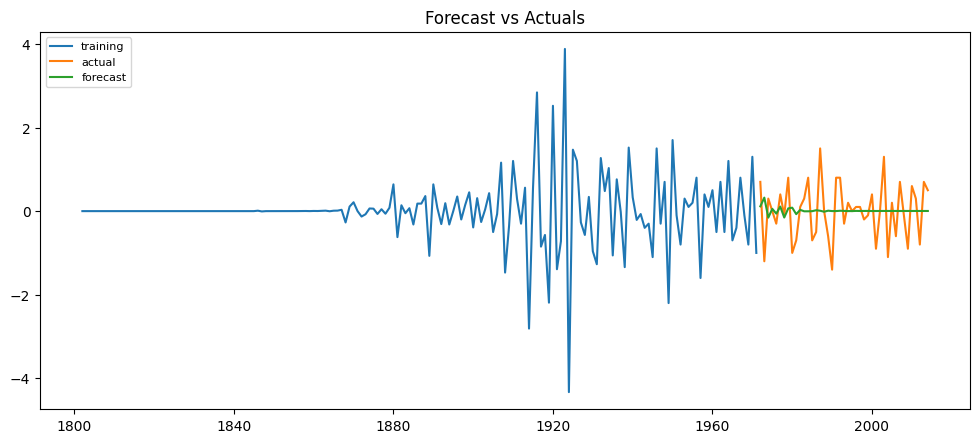

In [40]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [41]:
# only use q or MA parameter
#MA(3)
model_ma = ARIMA(train['Energy'],order = (0,1,3))
model_ma = model_ma.fit()
model_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Energy   No. Observations:                  170
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -147.611
Date:                Sun, 05 May 2024   AIC                            303.222
Time:                        21:28:54   BIC                            315.742
Sample:                    01-01-1802   HQIC                           308.303
                         - 01-01-1971                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.1042      1.504     -1.399      0.162      -5.053       0.844
ma.L2          1.2101      1.675      0.722      0.470      -2.074       4.494
ma.L3         -0.1055      0.177     -0.595      0.552      -0.453       0.242
sigma2         0.3035      0.459      0.662      0.508      -0.596       1.203
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               148.65
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):          100733.36   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})
stationary_aa_acc = forecast_accuracy(pred_ar.values, test.values)
stationary_aa_acc


{'mape': inf,
 'me': 0.007971834138912247,
 'mae': 0.5409508654870923,
 'mpe': nan,
 'rmse': 0.6742760980687206}

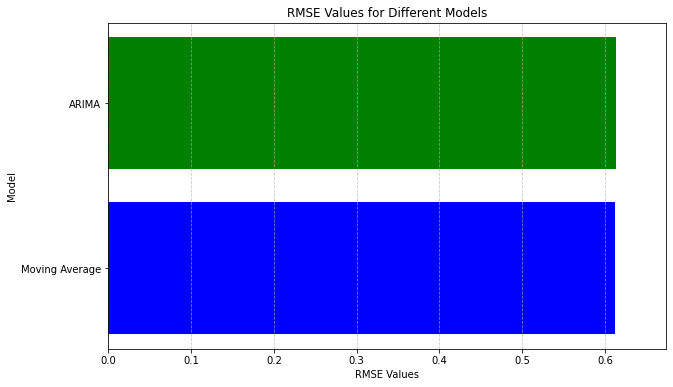

In [55]:
import matplotlib.pyplot as plt

# Data
models = ["Moving Average", "ARIMA"]
rmse_values = [0.611837, 0.613080]

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(models, rmse_values, color=['blue', 'green'])
plt.xlabel('RMSE Values')
plt.ylabel('Model')
plt.title('RMSE Values for Different Models')
plt.xlim(0, max(rmse_values) * 1.1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



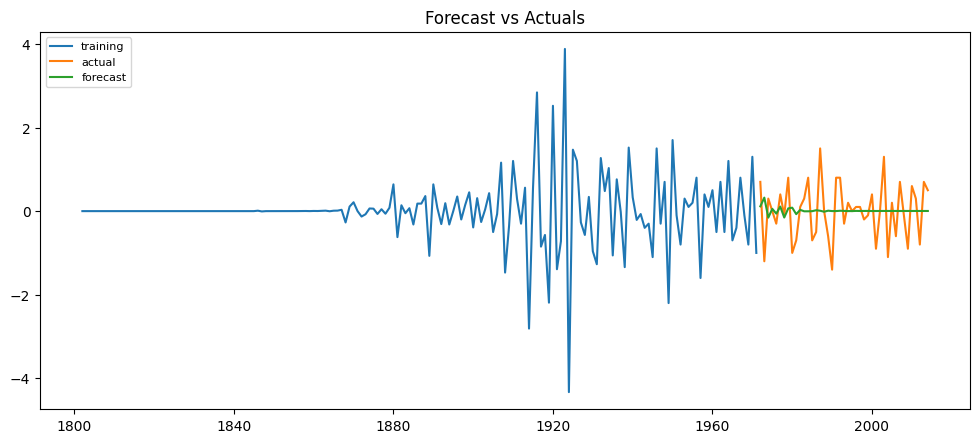

In [56]:
#MODEL BUILDING FOR NON STATIONARY DATA/ORIGNAL DATA
df.head()

,Energy
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [57]:
train = df[:195]
test = df[195:]
print(train.shape,test.shape)

(195, 1) (20, 1)


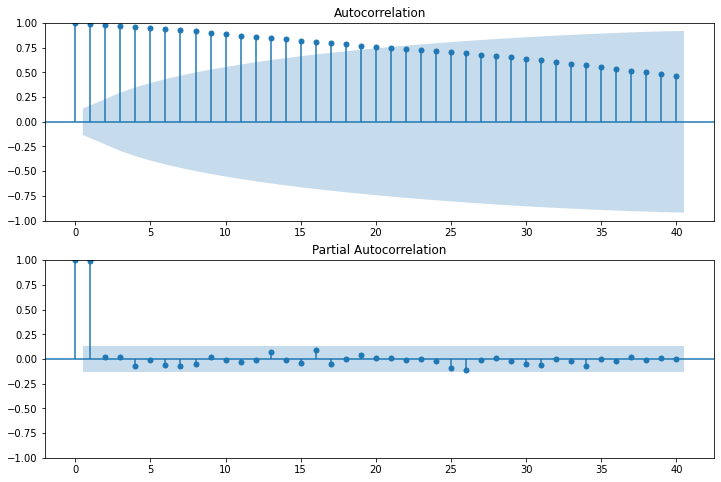

In [58]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

In [59]:
#FIND PDQ
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# evaluate parameters
p_values = [0,1,2,3,4,5]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=10.175
ARIMA(0, 0, 1) RMSE=5.218
ARIMA(0, 0, 2) RMSE=3.120
ARIMA(0, 0, 3) RMSE=1.965
ARIMA(0, 0, 4) RMSE=1.886
ARIMA(0, 1, 0) RMSE=0.438
ARIMA(0, 1, 1) RMSE=0.439
ARIMA(0, 1, 2) RMSE=0.439
ARIMA(0, 1, 3) RMSE=0.424
ARIMA(0, 1, 4) RMSE=0.424
ARIMA(0, 2, 0) RMSE=0.612
ARIMA(0, 2, 1) RMSE=0.451
ARIMA(0, 2, 2) RMSE=0.454
ARIMA(0, 2, 3) RMSE=0.458
ARIMA(0, 2, 4) RMSE=0.443
ARIMA(0, 3, 0) RMSE=1.037
ARIMA(0, 3, 1) RMSE=0.613
ARIMA(0, 3, 2) RMSE=0.450
ARIMA(0, 3, 3) RMSE=0.456
ARIMA(0, 3, 4) RMSE=0.460
ARIMA(0, 4, 0) RMSE=1.853
ARIMA(0, 4, 1) RMSE=1.039
ARIMA(0, 4, 2) RMSE=0.679
ARIMA(0, 4, 3) RMSE=0.438
ARIMA(0, 4, 4) RMSE=0.440
ARIMA(1, 0, 0) RMSE=0.437
ARIMA(1, 0, 1) RMSE=0.438
ARIMA(1, 0, 2) RMSE=0.438
ARIMA(1, 0, 3) RMSE=0.423
ARIMA(1, 0, 4) RMSE=0.423
ARIMA(1, 1, 0) RMSE=0.439
ARIMA(1, 1, 1) RMSE=0.433
ARIMA(1, 1, 2) RMSE=0.431
ARIMA(1, 1, 3) RMSE=0.437
ARIMA(1, 1, 4) RMSE=0.440
ARIMA(1, 2, 0) RMSE=0.544
ARIMA(1, 2, 1) RMSE=0.453
ARIMA(1, 2, 2) RMSE=0.446
ARIMA(1, 2,

In [62]:
#ASSUMING (P,D,Q) FROM ABOVE = (3,1,4)
model_arima = ARIMA(train['Energy'],order = (5,1,3))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Energy   No. Observations:                  195
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -157.059
Date:                Sun, 05 May 2024   AIC                            332.119
Time:                        22:46:44   BIC                            361.530
Sample:                    01-01-1800   HQIC                           344.028
                         - 01-01-1994                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0343      0.302      3.428      0.001       0.443       1.626
ar.L2          0.3299      0.529      0.624      0.533      -0.706       1.366
ar.L3         -0.4134      0.301     -1.375      0.169      -1.003       0.176
ar.L4         -0.0761      0.109     -0.700      0.484      -0.289       0.137
ar.L5         -0.0227      0.075     -0.303      0.762      -0.170       0.124
ma.L1         -1.0887      0.305     -3.565      0.000      -1.687      -0.490
ma.L2         -0.4031      0.547     -0.737      0.461      -1.475       0.669
ma.L3          0.6753      0.276      2.447      0.014       0.135       1.216
sigma2         0.2946      0.022     13.263      0.000       0.251       0.338
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                81.45
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):            4079.59   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
final_arima = ARIMA(df['Energy'],order = (5,1,3))
final_arima = final_arima.fit()
final_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Energy   No. Observations:                  215
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -167.228
Date:                Sun, 05 May 2024   AIC                            352.457
Time:                        22:48:15   BIC                            382.751
Sample:                    01-01-1800   HQIC                           364.698
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1018      0.300      3.678      0.000       0.515       1.689
ar.L2          0.3721      0.546      0.682      0.496      -0.698       1.442
ar.L3         -0.4164      0.308     -1.351      0.177      -1.020       0.188
ar.L4         -0.0978      0.114     -0.860      0.390      -0.321       0.125
ar.L5         -0.0726      0.081     -0.893      0.372      -0.232       0.087
ma.L1         -1.1804      0.309     -3.822      0.000      -1.786      -0.575
ma.L2         -0.4348      0.566     -0.769      0.442      -1.544       0.674
ma.L3          0.7304      0.285      2.559      0.011       0.171       1.290
sigma2         0.2756      0.023     12.065      0.000       0.231       0.320
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                84.97
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):             232.09   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
final_arima.fittedvalues.tail()

Year
2010-01-01    15.725993
2011-01-01    15.416806
2012-01-01    15.286119
2013-01-01    14.533077
2014-01-01    14.535113
dtype: float64

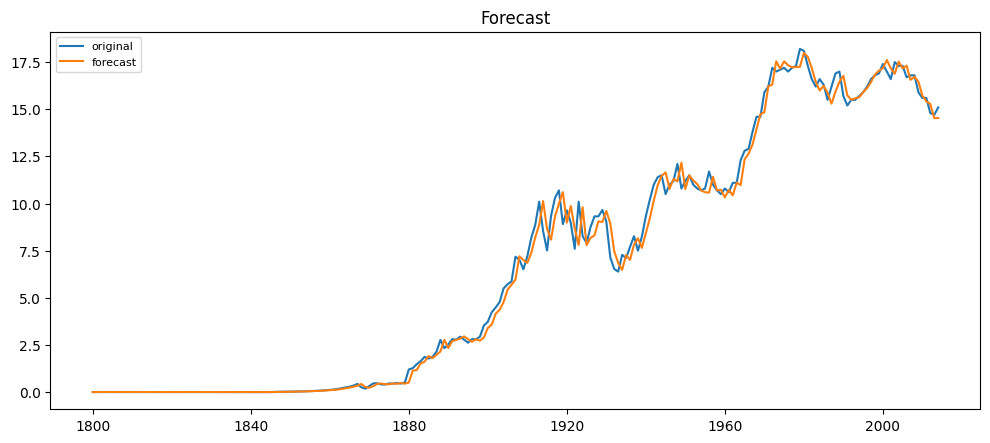

In [67]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(final_arima.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [69]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(years=x)for x in range(0,6)]
future_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df.tail()

,Energy
2015-01-01,NaN
2016-01-01,NaN
2017-01-01,NaN
2018-01-01,NaN
2019-01-01,NaN


In [70]:
len(future_df)

5

In [71]:
future_df['Energy'] = final_arima.predict(start = 215, end = 220, dynamic= True)  

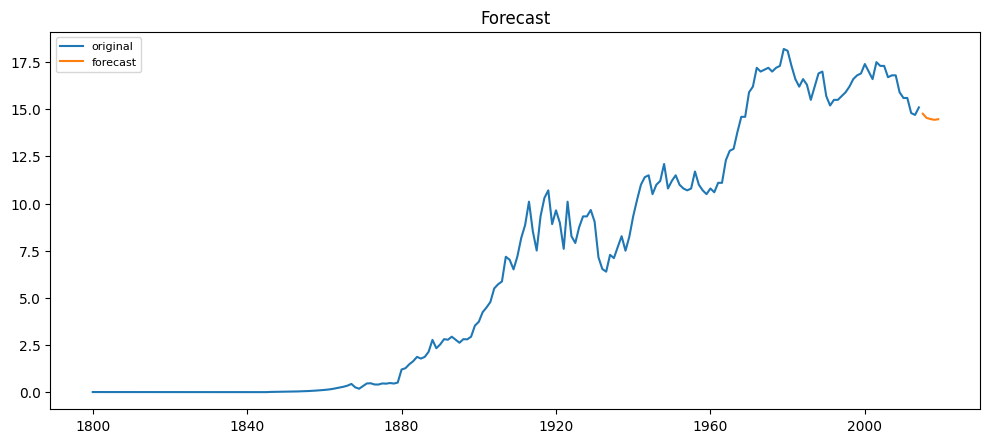

In [73]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df['Energy'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [74]:
df.tail()

,Energy
Year,
2010-01-01,15.6
2011-01-01,15.6
2012-01-01,14.8
2013-01-01,14.7
2014-01-01,15.1


In [75]:
#forecast for 5 years

future_df.tail()

,Energy
2015-01-01,14.765022
2016-01-01,14.540598
2017-01-01,14.482020
2018-01-01,14.441574
2019-01-01,14.472388


In [76]:
# Exporting to csv file
future_df.to_csv(r'forecast_data_5years.csv',index=True)

In [77]:
#FORECAST FOR 10 YEARS
future_dates_10=[df.index[-1]+ DateOffset(years=x)for x in range(0,11)]
future_df_10=pd.DataFrame(index=future_dates_10[1:],columns=df.columns)
future_df_10.tail()
len(future_df_10)

10

In [78]:
future_df_10['Energy'] = final_arima.predict(start = 215, end = 225, dynamic= True) 

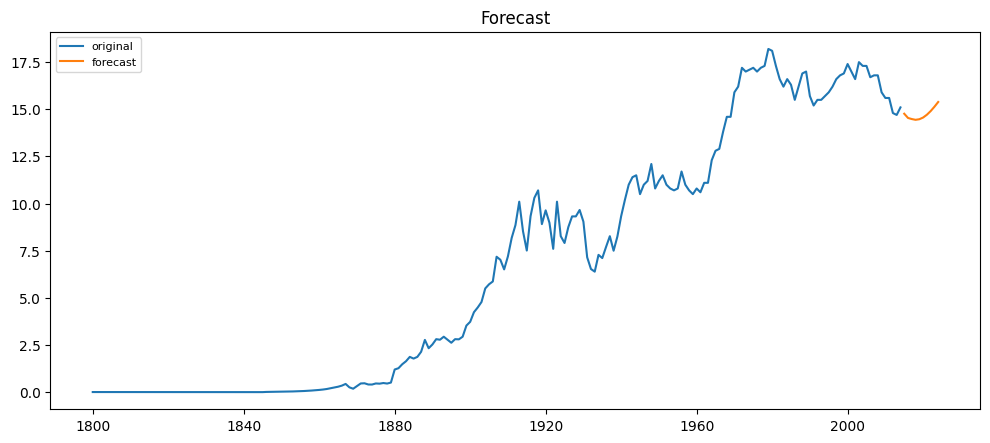

In [80]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df_10['Energy'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [81]:
future_df_10

,Energy
2015-01-01,14.765022
2016-01-01,14.540598
2017-01-01,14.482020
2018-01-01,14.441574
2019-01-01,14.472388
2020-01-01,14.561937
2021-01-01,14.710926
2022-01-01,14.903786
2023-01-01,15.134364
2024-01-01,15.387160


In [82]:
# Exporting to csv file
future_df_10.to_csv(r'forecast_data_10years.csv',index=True)

In [84]:
df = pd.read_csv("forecast_data_5years.csv")
df.head()

,Unnamed: 0,Energy
0,2015-01-01,14.765022
1,2016-01-01,14.540598
2,2017-01-01,14.482020
3,2018-01-01,14.441574
4,2019-01-01,14.472388


In [86]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

1995-01-01    15.724039
1996-01-01    15.730611
1997-01-01    15.764158
1998-01-01    15.775859
1999-01-01    15.789938
2000-01-01    15.793444
2001-01-01    15.794174
2002-01-01    15.788613
2003-01-01    15.780314
2004-01-01    15.769008
2005-01-01    15.756741
2006-01-01    15.744162
2007-01-01    15.732537
2008-01-01    15.722485
2009-01-01    15.714644
2010-01-01    15.709261
2011-01-01    15.706434
2012-01-01    15.706004
2013-01-01    15.707678
2014-01-01    15.711025
Freq: AS-JAN, Name: predicted_mean, dtype: float64


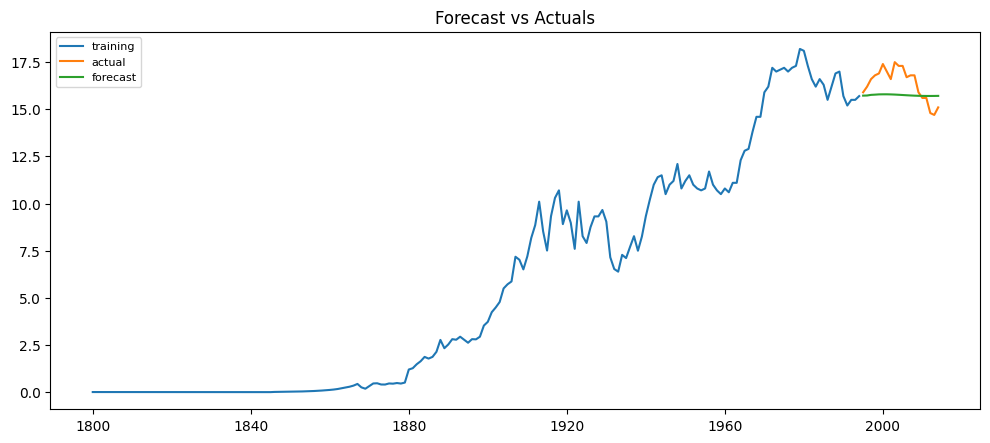

In [87]:
#ARIMA
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [104]:
ns_arima_acc = forecast_accuracy(pred_arima,test.Energy)
ns_arima_acc

{'mape': 0.054288861593328366,
 'me': -0.6289434254651655,
 'mae': 0.9029836471219724,
 'mpe': -0.03588307554059393,
 'rmse': 1.026856487786759}

In [106]:
model_auto = pm.auto_arima(train['Energy'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=327.249, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=328.890, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=328.788, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=329.304, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=330.241, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.386 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -161.625
Date:                Sun, 05 May 2024   AIC                            327.249
Time:                        23:08:39   BIC                            333.785
Sample:                    01-01-1800   HQIC                           329.896
                         - 01-01-1994                                         
Co

In [107]:
pred_auto_arima = model_auto.predict(start=start,end=end)
print(pred_auto_arima)

1995-01-01    15.780898
1996-01-01    15.861797
1997-01-01    15.942695
1998-01-01    16.023593
1999-01-01    16.104492
2000-01-01    16.185390
2001-01-01    16.266288
2002-01-01    16.347187
2003-01-01    16.428085
2004-01-01    16.508983
Freq: AS-JAN, dtype: float64


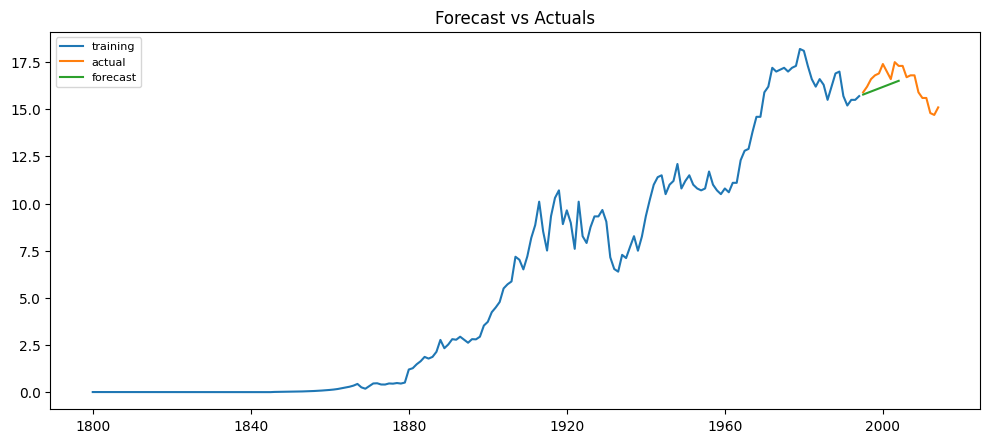

In [108]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_auto_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [109]:
#AUTO REGRESSOR
model_ar = AutoReg(train,lags = 1).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                 Energy   No. Observations:                  195
Model:                     AutoReg(1)   Log Likelihood                -161.622
Method:               Conditional MLE   S.D. of innovations              0.557
Date:                Sun, 05 May 2024   AIC                            329.245
Time:                        23:09:28   BIC                            339.048
Sample:                    01-01-1801   HQIC                           333.214
                         - 01-01-1994                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0784      0.055      1.420      0.156      -0.030       0.187
Energy.L1      1.0004      0.007    149.772      0.000       0.987       1.014
                                    Roots           

In [110]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

1995-01-01    15.785295
1996-01-01    15.870628
1997-01-01    15.955998
1998-01-01    16.041406
1999-01-01    16.126852
2000-01-01    16.212335
2001-01-01    16.297856
2002-01-01    16.383414
2003-01-01    16.469010
2004-01-01    16.554643
2005-01-01    16.640314
2006-01-01    16.726023
2007-01-01    16.811770
2008-01-01    16.897554
2009-01-01    16.983376
2010-01-01    17.069236
2011-01-01    17.155133
2012-01-01    17.241069
2013-01-01    17.327042
2014-01-01    17.413052
Freq: AS-JAN, dtype: float64


In [111]:
ns_ar_acc = forecast_accuracy(pred_ar.values, test.values)
ns_ar_acc

{'mape': 0.0498721151411498,
 'me': 0.2231003167408257,
 'mae': 0.7960986374051159,
 'mpe': 0.016375885511672343,
 'rmse': 0.9978427121395731}

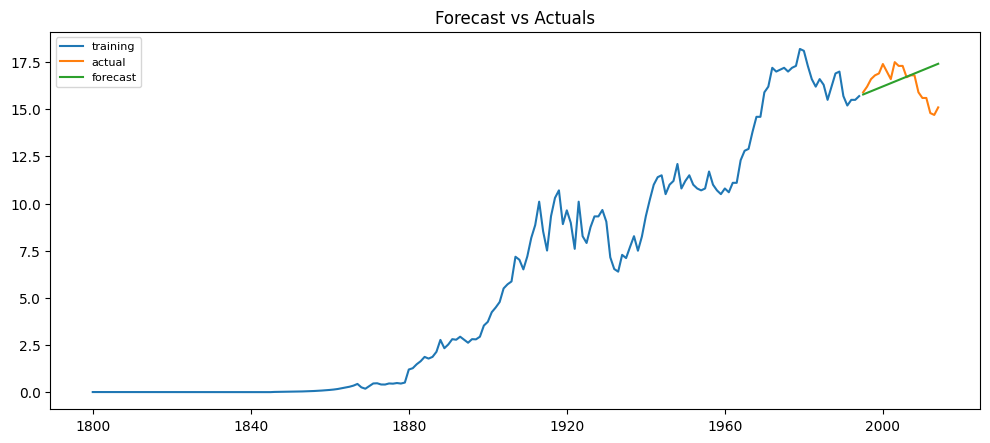

In [112]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Text(0.5, 1.0, 'Fitted values Vs Original Values')

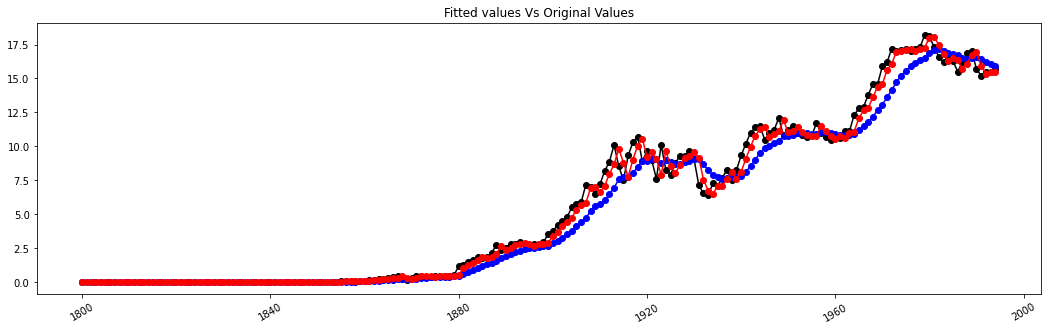

In [113]:
#SINGLE Exponential Smothing model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
fit1 = SimpleExpSmoothing(train).fit(smoothing_level = 0.2,optimized = False)
fit2 =SimpleExpSmoothing(train).fit(smoothing_level = 0.8,optimized = False)
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues,marker = 'o',color = 'blue')
plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [114]:

pred_ses = fit1.predict(start = len(train),end = len(train)+len(test)-1)

In [116]:
ns_ses_acc = forecast_accuracy(pred_ses,test.Energy)
ns_ses_acc

{'mape': 0.05140341313825273,
 'me': -0.48532979923801467,
 'mae': 0.8501648996190075,
 'mpe': -0.02700445758246523,
 'rmse': 0.9682045310926879}

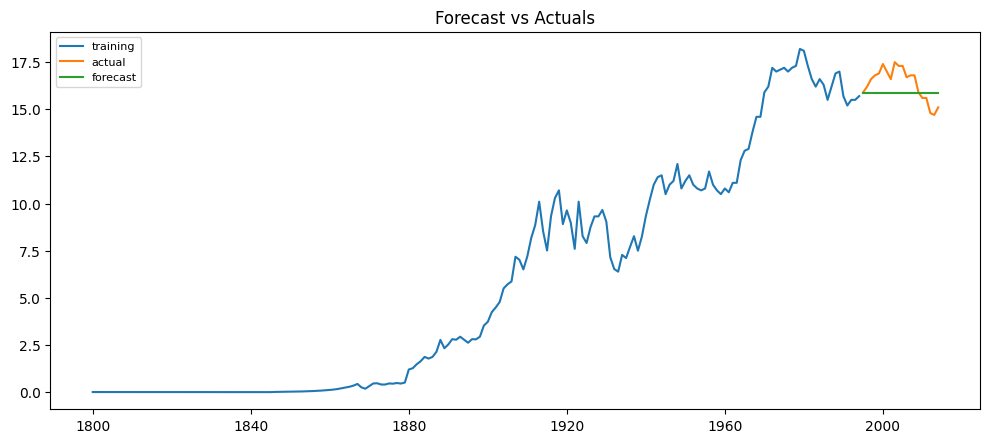

In [117]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Text(0.5, 1.0, 'Fitted values Vs Original Values')

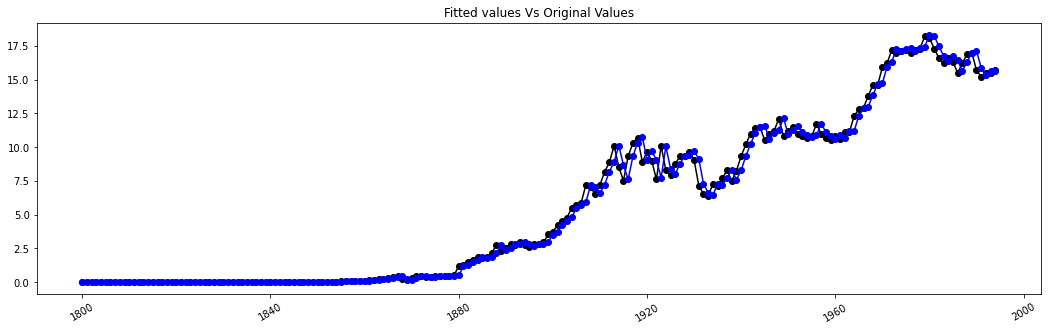

In [118]:
#Double Exponential Smoothing or Holt's method
#fit1 = Holt(train1).fit()
fit3 = Holt(train,exponential=True,damped_trend=False).fit()
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit3.fittedvalues,marker = 'o',color = 'blue')
#plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [120]:
pred_holt = fit3.predict(start = len(train),end = len(train)+len(test)-1)
ns_des_acc = forecast_accuracy(pred_holt,test.Energy)
ns_des_acc

{'mape': 0.06885595355345628,
 'me': 0.5496380331907044,
 'mae': 1.0796494118435482,
 'mpe': 0.03775867864970601,
 'rmse': 1.4774320194700215}

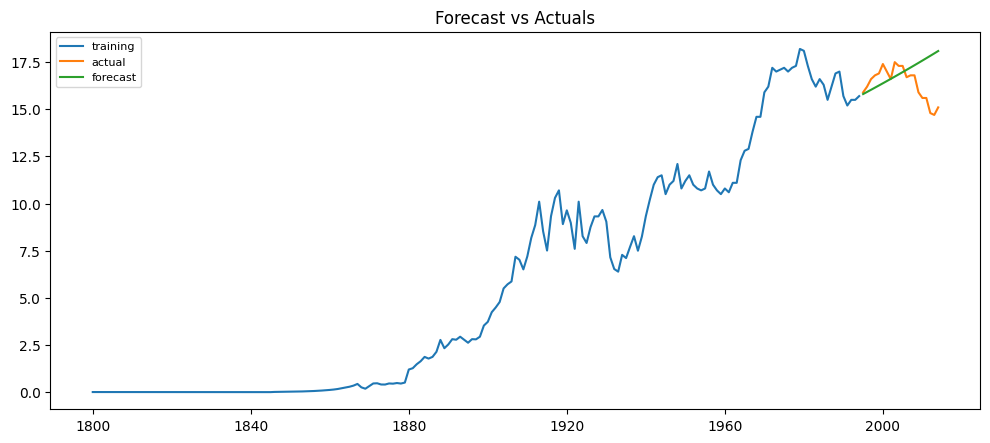

In [121]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [124]:
#Triple Exponential Smoothing or Holt - Winter's Method
hwe_model_add_add = ExponentialSmoothing(train["Energy"],seasonal="add",trend="add",seasonal_periods=2,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = start,end = end)
ns_tes_add_add_acc = forecast_accuracy(pred_hwe_add_add,test.Energy)
ns_tes_add_add_acc

{'mape': 0.05702149506115654,
 'me': -0.31152464265215585,
 'mae': 0.9298781150735138,
 'mpe': -0.015957638412746517,
 'rmse': 1.0228812050107008}

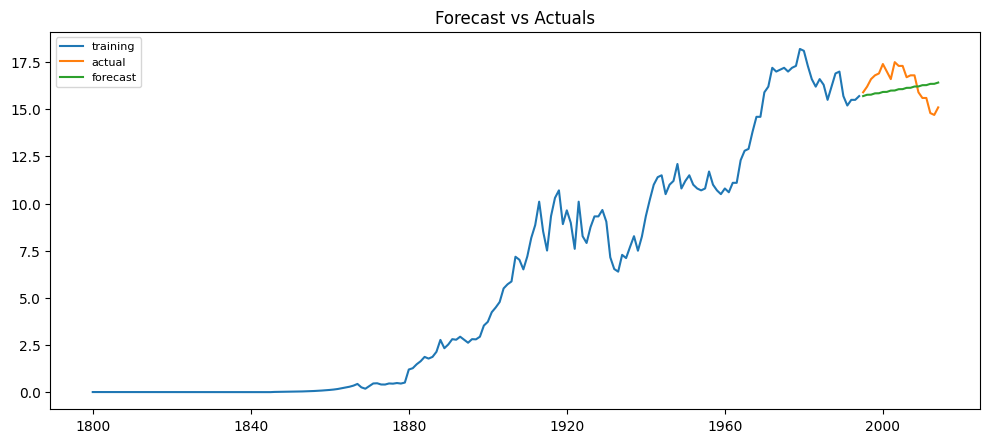

In [125]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_add_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [128]:
#LSTM
from sklearn.preprocessing import MinMaxScaler
from keras_preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_train[:10]

array([[0.00021595],
       [0.00021211],
       [0.00020881],
       [0.00020496],
       [0.00020167],
       [0.00019837],
       [0.00019452],
       [0.00019123],
       [0.00018793],
       [0.00018463]])

In [129]:
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)
X,y = generator[0]
print(f'given the array: \n{X.flatten()}')
print(f'predict this y: \n {y}')

given the array: 
[0.00021595 0.00021211 0.00020881 0.00020496 0.00020167]
predict this y: 
 [[0.00019837]]


In [130]:
model = Sequential()
model.add(LSTM(60, activation = 'relu',return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 60)          │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 60)          │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,061 (398.68 KB)

 Trainable params: 102,061 (398.68 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
last_train_batch = scaled_train[-5:]
last_train_batch = last_train_batch.reshape(1,n_input,n_features)

In [134]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


array([[-0.00027883]], dtype=float32)

In [135]:
scaled_test[0]

array([0.87361422])

In [143]:
test_predictions =[]

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)):
    
    #get the prediction value for first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis =1)
test_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[array([-0.00027883], dtype=float32),
 array([-0.00027501], dtype=float32),
 array([-0.00026348], dtype=float32),
 array([-0.00021479], dtype=float32),
 array([-0.00012226], dtype=float32),
 array([6.34532e-08], dtype=float32),
 array([5.7345012e-08], dtype=float32),
 array([4.6829236e-08], dtype=float32),
 array([2.9871302e-08], dtype=float32),
 array([1.1813557e-08], dtype=float32),
 array([-1.7240665e-11], dtype=float32),
 array([-1.4039794e-11], dtype=float32),
 array([-1.005056e-11], dtype=float32),
 array([-5.578108e-12], dtype=float32),
 array([-1.7258538e-12], dtype=float32),
 array([3.2949465e-15], dtype=float32),
 array([2.3895905e-15], dtype=float32),
 array([1.4508298e-15], dtype=float32),
 array([6.8557333e-16], dtype=float32),
 array([1.66845e-16], dtype=float32)]

In [149]:
ns_lstm_acc = forecast_accuracy(test['Predictions'],test.Energy)
ns_lstm_acc

{'mape': 0.9999568900630773,
 'me': -16.374300183779994,
 'mae': 16.374300183779994,
 'mpe': -0.9999568900630773,
 'rmse': 16.395720387625065}

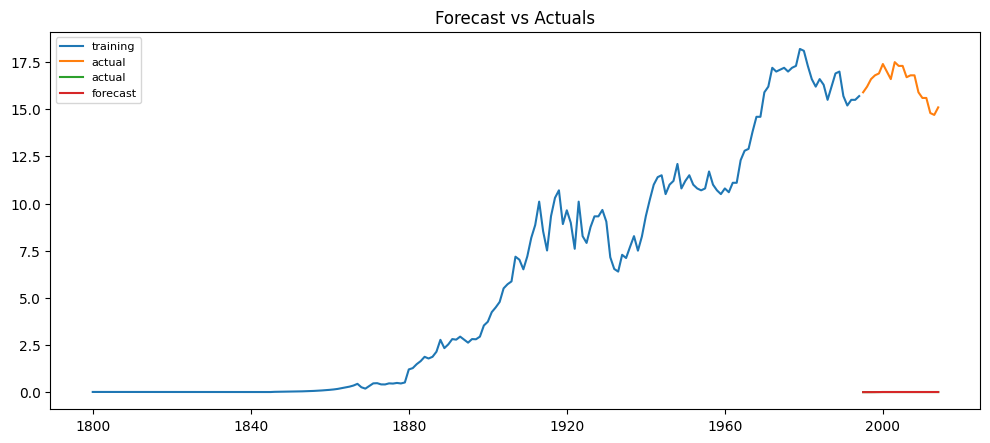

In [145]:

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(test['Predictions'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [150]:
import pandas as pd

data = {
    "MODEL": pd.Series([
        "ARIMA(3,1,4)", 
        "Auto Regressor", 
        "single exponential smoothing", 
        "Double exponential smoothing", 
        "Triple exponential smoothing(additive seasonality & additive trend)", 
        "LSTM(RNN)"
    ]),
    "RMSE_values": pd.Series([
        ns_arima_acc["rmse"],
        ns_ar_acc["rmse"],
        ns_ses_acc["rmse"],
        ns_des_acc["rmse"],
        ns_tes_add_add_acc["rmse"],
        ns_lstm_acc["rmse"]
    ]),
    "MAPE_values": pd.Series([
        ns_arima_acc["mape"],
        ns_ar_acc["mape"],
        ns_ses_acc["mape"],
        ns_des_acc["mape"],
        ns_tes_add_add_acc["mape"],
        ns_lstm_acc["mape"]
    ]),
    "ME_values": pd.Series([
        ns_arima_acc["me"],
        ns_ar_acc["me"],
        ns_ses_acc["me"],
        ns_des_acc["me"],
        ns_tes_add_add_acc["me"],
        ns_lstm_acc["me"]
    ]),
    "MAE_values": pd.Series([
        ns_arima_acc["mae"],
        ns_ar_acc["mae"],
        ns_ses_acc["mae"],
        ns_des_acc["mae"],
        ns_tes_add_add_acc["mae"],
        ns_lstm_acc["mae"]
    ]),
    "MPE_values": pd.Series([
        ns_arima_acc["mpe"],
        ns_ar_acc["mpe"],
        ns_ses_acc["mpe"],
        ns_des_acc["mpe"],
        ns_tes_add_add_acc["mpe"],
        ns_lstm_acc["mpe"]
    ])
}

table_rmse = pd.DataFrame(data)

# Exclude models "Triple exponential smoothing(multiplicative seasonality & additive trend)" and "Triple exponential smoothing(multiplicative seasonality & multiplicative trend)"
table_rmse = table_rmse[~table_rmse['MODEL'].isin([
    "Triple exponential smoothing(multiplicative seasonality & additive trend)", 
    "Triple exponential smoothing(multiplicative seasonality & multiplicative trend)"
])]

# Sort the DataFrame based on MAPE_values
sorted_table_rmse = table_rmse.sort_values(['MAPE_values'])

print(sorted_table_rmse)


                                               MODEL  RMSE_values  \
1                                     Auto Regressor     0.997843   
2                       single exponential smoothing     0.968205   
0                                       ARIMA(3,1,4)     1.026856   
4  Triple exponential smoothing(additive seasonal...     1.022881   
3                       Double exponential smoothing     1.477432   
5                                          LSTM(RNN)    16.395720   

   MAPE_values  ME_values  MAE_values  MPE_values  
1     0.049872   0.223100    0.796099    0.016376  
2     0.051403  -0.485330    0.850165   -0.027004  
0     0.054289  -0.628943    0.902984   -0.035883  
4     0.057021  -0.311525    0.929878   -0.015958  
3     0.068856   0.549638    1.079649    0.037759  
5     0.999957 -16.374300   16.374300   -0.999957  


In [157]:
import pandas as pd

# Example data with Evaluation 1 RMSE values for each model
data = {
    "MODEL": [
        "ARIMA(3,1,4)", 
        "Auto Regressor", 
        "Single Exponential Smoothing", 
        "Double Exponential Smoothing", 
        "Triple Exponential Smoothing (Additive Seasonality & Additive Trend)", 
        "LSTM(RNN)"
    ],
    "Evaluation1_RMSE": [
        0.997843,
        0.968205,
        1.026856,
        1.022881,
        1.477432,
         0.8833397963583586
    ]
}

# Create DataFrame
table_rmse = pd.DataFrame(data)

# Rank the models based on Evaluation 1 RMSE values
table_rmse['Rank'] = table_rmse['Evaluation1_RMSE'].rank()

# Display the DataFrame with rankings
print(table_rmse.sort_values(by='Rank'))



                                               MODEL  Evaluation1_RMSE  Rank
5                                          LSTM(RNN)          0.883340   1.0
1                                     Auto Regressor          0.968205   2.0
0                                       ARIMA(3,1,4)          0.997843   3.0
3                       Double Exponential Smoothing          1.022881   4.0
2                       Single Exponential Smoothing          1.026856   5.0
4  Triple Exponential Smoothing (Additive Seasona...          1.477432   6.0


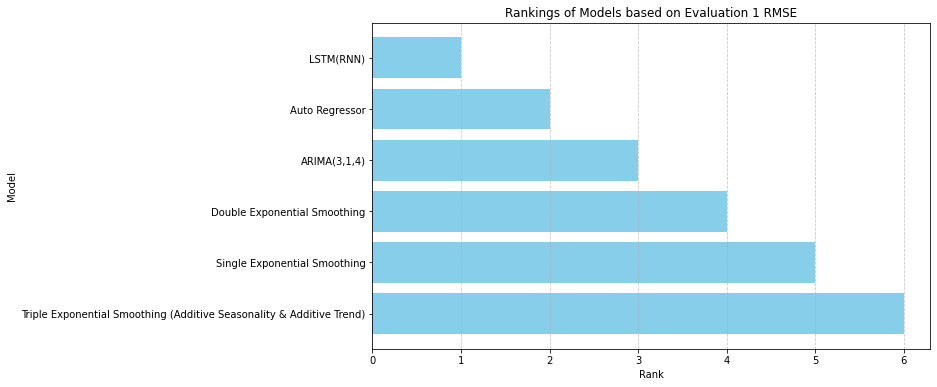

In [158]:
import matplotlib.pyplot as plt

# Sort the DataFrame by Rank
sorted_table_rmse = table_rmse.sort_values(by='Rank')

# Create bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_table_rmse['MODEL'], sorted_table_rmse['Rank'], color='skyblue')
plt.xlabel('Rank')
plt.ylabel('Model')
plt.title('Rankings of Models based on Evaluation 1 RMSE')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [138]:
test.head()

,Energy
Year,
1995-01-01,15.9
1996-01-01,16.2
1997-01-01,16.6
1998-01-01,16.8
1999-01-01,16.9
